# Sentiment Analysis on Airline tweets

This project performs sentiment analysis on airline-related tweets using Natural Language Processing (NLP). It involves data cleaning, feature extraction using TF-IDF, and model training to classify tweets into positive, neutral, or negative sentiments. Visualizations and insights are also included to interpret the model's performance

# Step 1: Import Libraries

In [11]:
#import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for text processing
import re
import string

#import Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#natural language toolkit for stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step2: Load Dataset

In [4]:
df=pd.read_csv('Tweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Step3: Handling missing values

In [6]:
# check missing values
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
# drop irrlevant columns
df.drop(columns=['airline_sentiment_gold','negativereason_gold','negativereason','tweet_coord'],inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   name                          14640 non-null  object 
 6   retweet_count                 14640 non-null  int64  
 7   text                          14640 non-null  object 
 8   tweet_created                 14640 non-null  object 
 9   tweet_location                9907 non-null   object 
 10  user_timezone                 9820 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1.2+ MB


# Step 4: clean the tweets

In [14]:
#function to clean text data
stop_words=set(stopwords.words('English'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"https\S + www\S + |https\S",'',text)        #remove URLs
    text = re.sub(r"@\w|#\W+",'',text)          #remove mentions and hashtags
    text = re.sub(r"[^a-z\s]",'',text)          #remove special characters and numbers

    text = text.translate(str.maketrans('','',string.punctuation))   #remove punctuations
    words = text.split() #tokenize
    words = [word for word in words if word not in stop_words]       #remove stopwords
  
    return " ".join(words)        #join back into one clean string

#apply the function to the tweets
df['clean_text'] = df['text'].apply(clean_text)

# Step 5: Encode the Sentiment labels

In [15]:
#Map text labels to numbers
label_map = {'negative':0, 'neutral':1, 'positive':2}
df['label'] = df['airline_sentiment'].map(label_map)

In [16]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_text,label
0,570306133677760513,neutral,1.0000,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),irginamerica hepburn said,1
1,570301130888122368,positive,0.3486,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),irginamerica plus youve added commercials expe...,2
2,570301083672813571,neutral,0.6837,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),irginamerica didnt today must mean need take a...,1
3,570301031407624196,negative,1.0000,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),irginamerica really aggressive blast obnoxious...,0
4,570300817074462722,negative,1.0000,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),irginamerica really big bad thing,0


# Step 6 : Basic sentiment Distribution

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13168\148550152.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment',data=df, palette='cool')


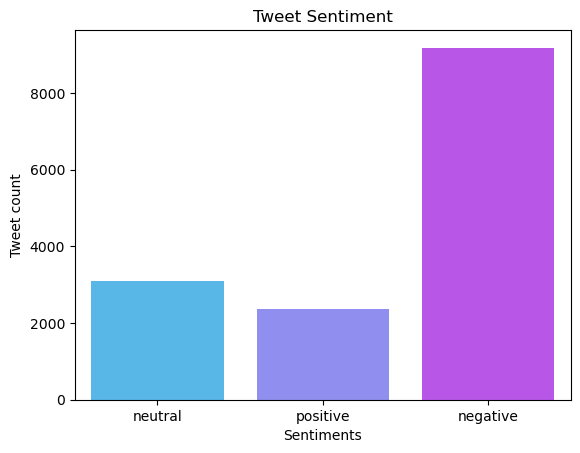

In [18]:
sns.countplot(x='airline_sentiment',data=df, palette='cool')
plt.title('Tweet Sentiment')
plt.xlabel('Sentiments')
plt.ylabel('Tweet count')
plt.show()

### Sentiment Distribution Overview

This bar chart shows the distribution of tweet sentiments in the dataset.  
We can observe the following:

- **Negative tweets** are the most common, which indicates frequent user complaints or issues.
- **Neutral tweets** appear less often but still form a significant portion.
- **Positive tweets** are the least frequent, suggesting that users tend to tweet more when dissatisfied.

This imbalance may influence model performance and should be kept in mind during training and evaluation.


# Step 7: TF-IDF vectorization

In [20]:
#convert cleaned text to TF-IDF features
tfidf = TfidfVectorizer(max_features=3000)
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label']

# Step 8: Train-test split

In [21]:
# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42)

# Step 9 :  Train the model

In [22]:
# use logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

# Step 10: Evaluate the model

Accuracy Score : 0.8005464480874317

 Classification report:

              precision    recall  f1-score   support

    Negative       0.82      0.94      0.88      1889
     Neutral       0.68      0.49      0.57       580
    Positive       0.80      0.63      0.71       459

    accuracy                           0.80      2928
   macro avg       0.77      0.69      0.72      2928
weighted avg       0.79      0.80      0.79      2928



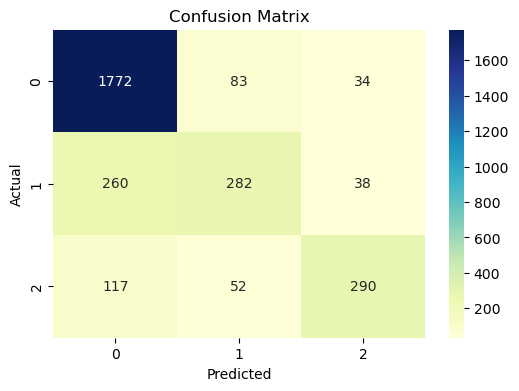

In [23]:
#Predict and evaluate
y_pred = model.predict(x_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred))
print("\n Classification report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))

#plot confusion matrix
plt.figure(figsize  = (6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt= 'd', cmap= 'YlGnBu')

xticklabels = ['Negative', 'Neutral', 'Positive']
yticklabels = ['Negative', 'Neutral', 'Positive']

plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##  Confusion Matrix Interpretation

- The confusion matrix shows how well the model predicted each sentiment class.
- Most **Negative** tweets were predicted correctly (1772).
- The model struggled more with **Neutral** tweets, confusing them with Negative.
- **Positive** tweets were also mostly predicted correctly (290).
- Overall, the model performs well on Negative and Positive sentiments, with some confusion in Neutral predictions.


# Step 11 : Show top words per sentiment class


 Top 10 words for Negative tweets:
abq(-0.545)
able(-0.186)
abc( 0.045)
absurd( 0.600)
ability( 0.175)
aadvantage(-0.600)
absolute( 0.463)
abt( 0.280)
aa( 0.235)
absolutely( 0.024)


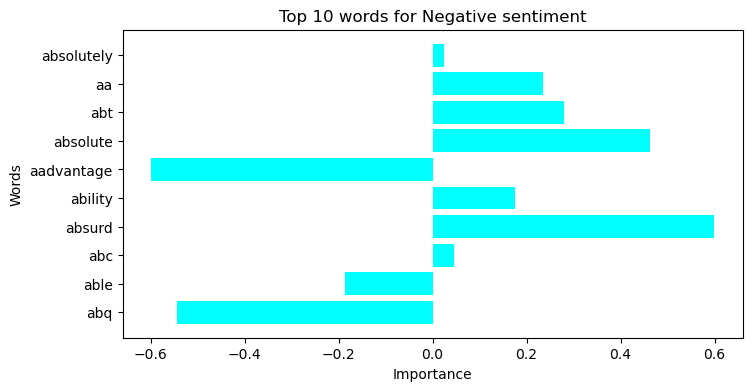


 Top 10 words for Neutral tweets:
aa( 0.323)
absolutely(-0.410)
absolute(-0.325)
abt(-0.296)
abc( 0.246)
able(-0.618)
aadvantage( 0.708)
ability(-0.258)
abq( 0.461)
absurd(-0.453)


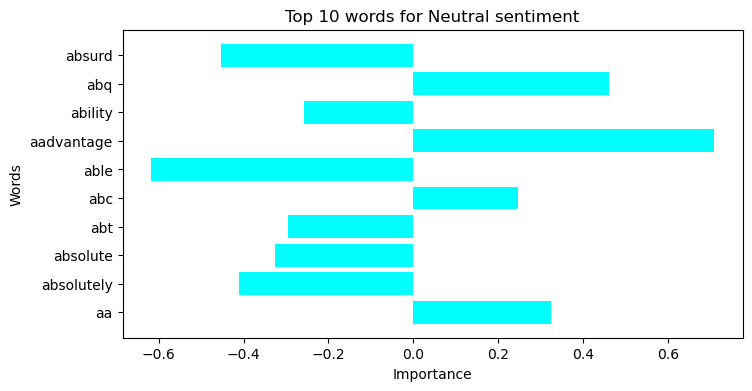


 Top 10 words for Positive tweets:
absolutely( 0.386)
aadvantage(-0.108)
ability( 0.082)
absurd(-0.147)
abt( 0.016)
abq( 0.084)
absolute(-0.138)
able( 0.805)
abc(-0.291)
aa(-0.558)


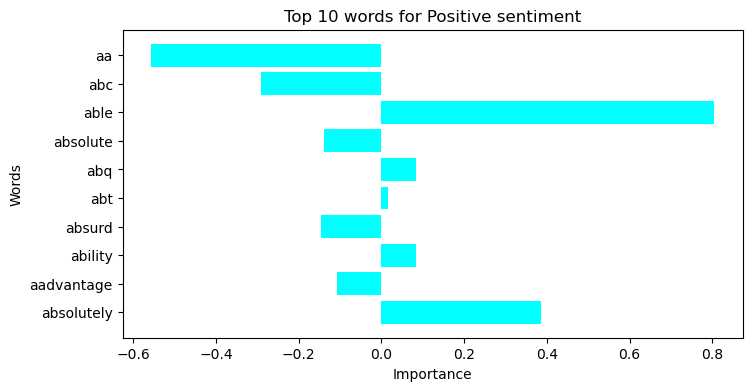

In [35]:
#get feature name and model coefficients
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_

#loop through each sentiment class
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    top_indices = np.argsort(coefs[i][-10:])   #top 10 wrord indices
    top_words=[feature_names[j] for j in top_indices]  #corresponding features
    top_weights=[coefs[i][j] for j in top_indices]  #correspoding weights
    print(f"\n Top 10 words for {label} tweets:")  #top 10 words with weights
   
    for word, weight in zip(top_words, top_weights):
         print(f"{word}({weight: .3f})")
        
   

    #plot the top 10 words for current sentiment class
    plt.figure(figsize = (8,4))
    plt.barh(top_words, top_weights, color='aqua')
    plt.title(f"Top 10 words for {label} sentiment")
    plt.xlabel("Importance")
    plt.ylabel("Words")
    plt.show()
    

## Step 11: Model Insights – Most Influential Words per Sentiment

To interpret the trained model, we analyze the top 10 words that most strongly influence predictions for each sentiment class. These words have the highest positive weights in the logistic regression model for that class.

This helps us understand how the model decides whether a tweet is **Negative**, **Neutral**, or **Positive**.
